In [1]:
# grab model checkpoint from huggingface hub
from huggingface_hub import hf_hub_download
import torch
# from open_flamingo import create_model_and_transforms
from Flamingo.lora_tuning import create_model_and_transforms
from PIL import Image
import requests
import torch
from transformers.tokenization_utils_base import BatchEncoding
from IPython.display import clear_output
cache_dir = "/home/yunzhi/yunzhi/yunzhi/checkpoints/flamingo"
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",
    tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",
    cross_attn_every_n_layers=1,
    cache_dir= cache_dir, # Defaults to ~/.cache
    lora_tuning=True,
    # add_eos_token=True
)

# checkpoint_path = hf_hub_download("openflamingo/OpenFlamingo-3B-vitl-mpt1b", "checkpoint.pt", cache_dir=cache_dir)
# checkpoint_path = "/home/yunzhi/yunzhi/yunzhi/checkpoints/flamingo/checkpoint.pt"
# model.load_state_dict(torch.load(checkpoint_path), strict=False)
clear_output()

Flamingo will use single GPU or CPU

[@rank-1|create Flamingo] create vision_encoder and image_processor from open_clip

[@rank-1|create Flamingo] create text_tokenizer

[@rank-1|create Flamingo] create LLM from  anas-awadalla/mpt-1b-redpajama-200b

/home/yunzhi/.cache/huggingface/modules/transformers_modules/anas-awadalla/mpt-1b-redpajama-200b/50d6bc94e17812873f39c36c5f815263fa71fb80/attention.py:289: UserWarning: Using `attn_impl: torch`. If your model does not use `alibi` or `prefix_lm` we recommend using `attn_impl: flash` otherwise we recommend using `attn_impl: triton`.
  warnings.warn(


You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


[@rank-1|create Flamingo] create Flamingo with cross_attn_every_n_layers= 1

KeyboardInterrupt: 

In [3]:
state_dict = torch.load("/home/yunzhi/yunzhi/yunzhi/VLLM/retrieval/work_dir/50/loRA.pth")
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['base_model.model.vision_encoder.class_embedding', 'base_model.model.vision_encoder.positional_embedding', 'base_model.model.vision_encoder.proj', 'base_model.model.vision_encoder.conv1.weight', 'base_model.model.vision_encoder.ln_pre.weight', 'base_model.model.vision_encoder.ln_pre.bias', 'base_model.model.vision_encoder.transformer.resblocks.0.ln_1.weight', 'base_model.model.vision_encoder.transformer.resblocks.0.ln_1.bias', 'base_model.model.vision_encoder.transformer.resblocks.0.attn.in_proj_weight', 'base_model.model.vision_encoder.transformer.resblocks.0.attn.in_proj_bias', 'base_model.model.vision_encoder.transformer.resblocks.0.attn.out_proj.weight', 'base_model.model.vision_encoder.transformer.resblocks.0.attn.out_proj.bias', 'base_model.model.vision_encoder.transformer.resblocks.0.ln_2.weight', 'base_model.model.vision_encoder.transformer.resblocks.0.ln_2.bias', 'base_model.model.vision_encoder.transformer.resblocks.0.mlp.c_fc.weight', 'base_mo

In [2]:
device = 0

In [3]:
def to_cuda(data, device=0):
    if isinstance(data, BatchEncoding):
        # k: ['input_ids', 'attention_mask']
        for k in data:
            data[k] = data[k].cuda(device)
    return data 
model = model.cuda(device)

In [4]:


"""
Step 1: Load images
"""
# demo_image_one = Image.open(
#     requests.get(
#         "http://images.cocodataset.org/val2017/000000039769.jpg", stream=True
#     ).raw
# )

# demo_image_two = Image.open(
#     requests.get(
#         "http://images.cocodataset.org/test-stuff2017/000000028137.jpg",
#         stream=True
#     ).raw
# )

# query_image = Image.open(
#     requests.get(
#         "http://images.cocodataset.org/test-stuff2017/000000028352.jpg", 
#         stream=True
#     ).raw
# )
demo_image_two = Image.open("./images/2.jpg")
demo_image_one = Image.open("./images/1.jpg")
# demo_image_one = Image.open("./images/night.jpg")
# query_image = Image.open("./images/snow.jpg")
# query_image = Image.open("./images/night.jpg")
query_image = Image.open("./images/yellow_bus.jpg")

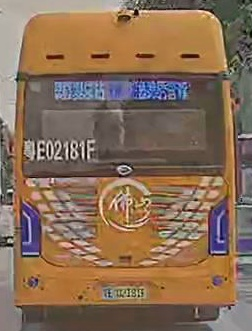

In [5]:
query_image

In [7]:
"""
Step 2: Preprocessing images
Details: For OpenFlamingo, we expect the image to be a torch tensor of shape 
 batch_size x num_media x num_frames x channels x height x width. 
 In this case batch_size = 1, num_media = 3, num_frames = 1,
 channels = 3, height = 224, width = 224.
"""
vision_x = [image_processor(query_image).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0).cuda(device)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)
vision_x.shape

torch.Size([1, 1, 1, 3, 224, 224])

In [8]:
"""
Step 3: Preprocessing text
Details: In the text we expect an <image> special token to indicate where an image is.
 We also expect an <|endofchunk|> special token to indicate the end of the text 
 portion associated with an image.
"""

TEMPLATE = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Image:\n<image>\n\n### Instruction:\nWhat is this ?'
TEMPLATE = 'Question: {}'.format(TEMPLATE)
tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>The color is"],
    return_tensors="pt",
)
lang_x = to_cuda(lang_x, device=device)

In [12]:

"""
Step 4: Generate text
"""
generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)
print("Generated text: ", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image>The color is not the only thing that has changed on the bus.<|endofchunk|>


In [12]:
# print(model.base_model.model.lang_encoder)